In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np

import bayesflow as bf

from inverse_kinematics import InverseKinematicsModel

INFO:bayesflow:Using backend 'torch'
When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you need gradients (e.g. custom training loops).


In [3]:
# Observation from https://arxiv.org/abs/2101.10763
obs = {"observables": np.array([0, 1.5])}

In [4]:
files = os.listdir("samples")


kinematics_samples = {
    f.replace("_inverse_kinematics.npy", ""): np.load(os.path.join("samples", f)) for f in files if "kinematics" in f
}

In [5]:
kinematics_samples.keys()

dict_keys(['abc', 'diffusion_edm_ve', 'diffusion_cosine_noise', 'consistency_model', 'flow_matching', 'diffusion_edm_vp', 'ot_flow_matching', 'diffusion_cosine_v', 'stable_consistency_model', 'diffusion_cosine_F'])

In [6]:
titles = {
    "abc": "ABC-SMC",
    "diffusion_edm_ve": "EDM VE",
    "diffusion_edm_vp": "EDM VP",
    "diffusion_cosine_noise": "Cosine Noise",
    "diffusion_cosine_v": r"Cosine $\mathbf{v}$",
    "diffusion_cosine_F": r"Cosine $\mathbf{F}$",
    "flow_matching": "Flow Matching",
    "ot_flow_matching": "Flow Matching (OT)",
    "consistency_model": "Consistency Model",
    "stable_consistency_model": "Stable Consistency Model"
}


colors = {
    "abc": "maroon",
    "diffusion_edm_ve": "#FB9A99",
    "diffusion_edm_vp": "#E7298A",
    "diffusion_cosine_noise": "#54278F",
    "diffusion_cosine_v": "#9E9AC8",
    "diffusion_cosine_F": "#7570B3",
    "flow_matching": "#1B9E77",
    "ot_flow_matching": "#33A02C",
    "consistency_model": "#D95F02",
    "stable_consistency_model": "#E6AB02"
}

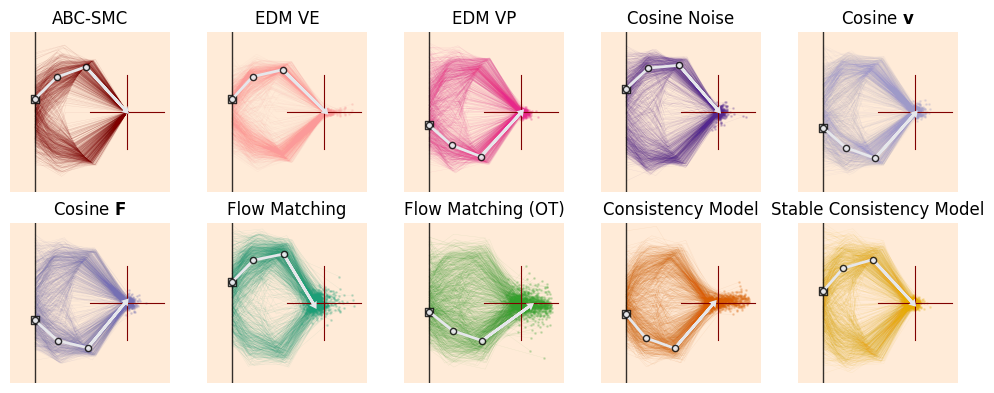

In [13]:
fig, axarr = plt.subplots(2, len(kinematics_samples) // 2, figsize=(10, 4), subplot_kw=dict(box_aspect=1), squeeze=False)

for name, ax in zip(titles, axarr.flat):
     m = InverseKinematicsModel(linecolors=[colors[name]] * 3)
     m.update_plot_ax(ax, kinematics_samples[name][:1000], obs["observables"][::-1], exemplar_color="#e6e7eb")

for title, ax in zip(titles, axarr.flat):
    ax.grid(False)
    ax.patch.set_facecolor('#FFE5CC')
    ax.patch.set_alpha(0.75)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.spines["bottom"].set_alpha(0.0)
    ax.spines["top"].set_alpha(0.0)
    ax.spines["right"].set_alpha(0.0)
    ax.spines["left"].set_alpha(0.0)
    ax.set_aspect('equal')
    ax.set_title(titles[title])

fig.tight_layout()

In [ ]:
fig.savefig("plots/inv_kinematics_samples.pdf", dpi=300)